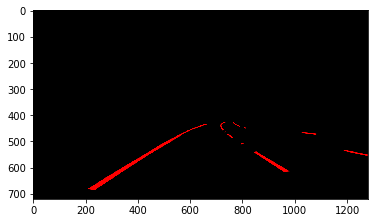

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_colors = [
        ([240, 20, 20]), #lane lines
        ([0, 0, 0]), #background        
    ]

filename = 'test_images/test5_lanes.png'

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [2]:
def prepare_mask(img, class_colors, thresh):
    mask_channels = []
    for col in class_colors:
        lower = np.array(col) - thresh
        upper = np.array(col) + thresh
        mask = cv2.inRange(img, lower, upper)
        mask_channels.append(mask)

    return np.array(mask_channels)

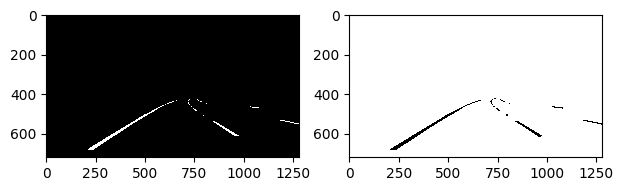

In [3]:
mask = prepare_mask(img, class_colors, thresh=20)

plt.rcdefaults()
fig = plt.figure(figsize=(15,20))

nb_ch = len(class_colors)
n = 1
for channal_mask in mask:
    plt.subplot(nb_ch,4, n)
    plt.imshow(channal_mask,cmap='gray')
    n += 1
plt.show()


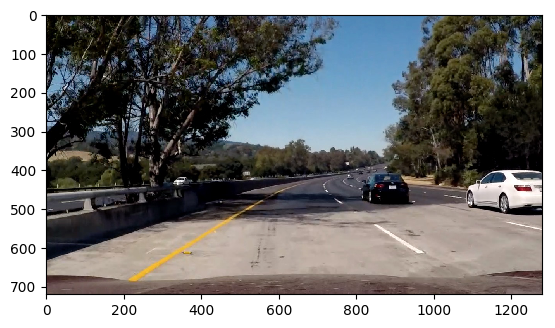

In [4]:
filename = 'test_images/test5.jpg'

road_img = cv2.imread(filename)
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)

plt.imshow(road_img)
plt.show()

In [5]:
def display_three_channels(channels, labels):
    f, subplt = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    for i in range(3):
        subplt[i].imshow(channels[i], cmap='gray')
        subplt[i].set_title(labels[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def display_n_images(images, labels, cmaps):
    n = len(images)
    f, subplt = plt.subplots(1, n, figsize=(24, 9))
    f.tight_layout()
    for i in range(n):
        subplt[i].imshow(images[i], cmap=cmaps[i])
        subplt[i].set_title(labels[i], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def thresh_mask(img, thresh, val=0.1):
    flt_img = np.zeros_like(img, dtype=float)
    flt_img[(img > thresh[0]) & (img <= thresh[1])] = val
    return flt_img

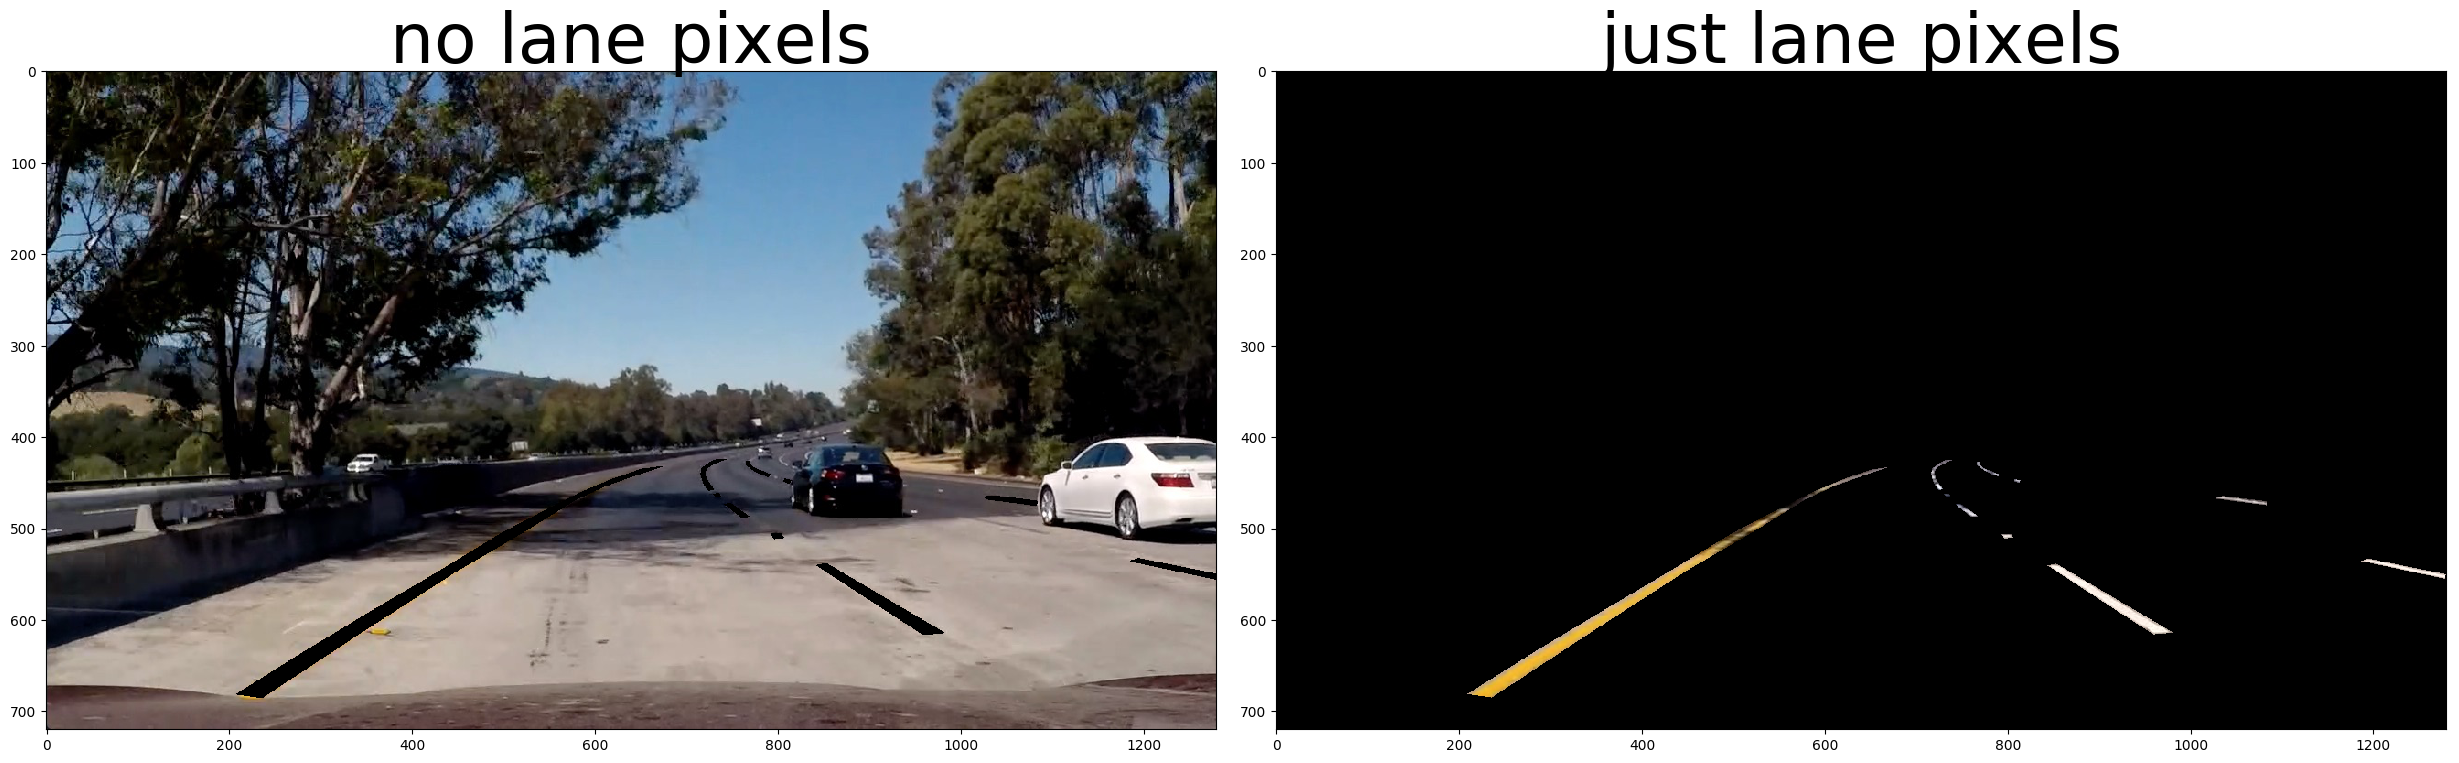

In [6]:
not_lane_lines = np.copy(road_img)
other_masks = mask[1] #not lane lines
not_lane_lines[(other_masks == 0)] = 0

just_lane_lines = np.copy(road_img)
just_lane_lines[(mask[0] == 0)] = 0

display_n_images((not_lane_lines, just_lane_lines), ("no lane pixels", 'just lane pixels'), (None, None))

(720, 1280, 3)


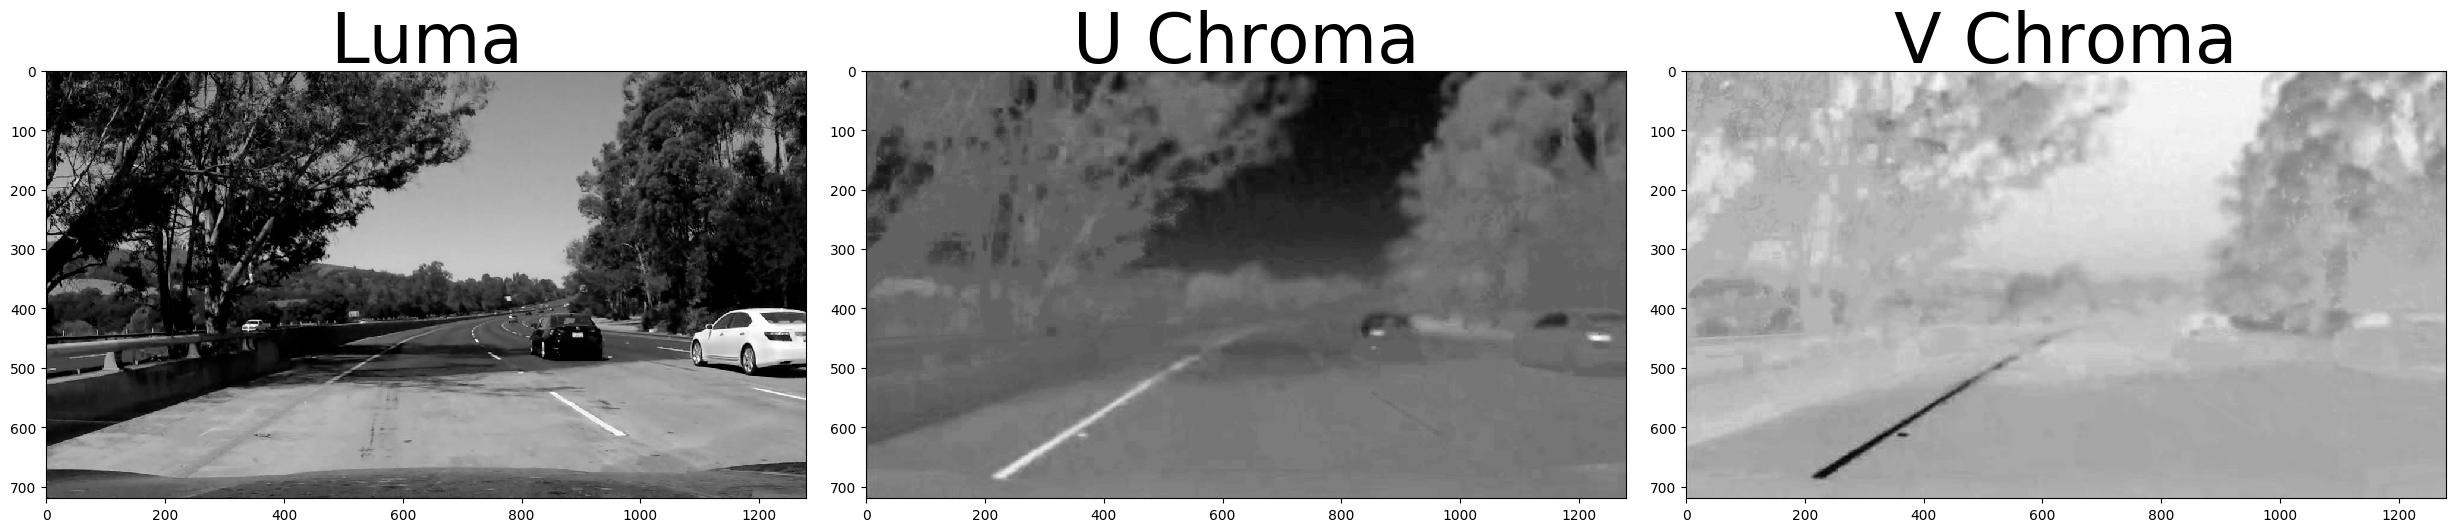

In [7]:
yuv = cv2.cvtColor(road_img, cv2.COLOR_RGB2YUV)
print(yuv.shape)
Y, U, V = cv2.split(yuv)

channel_labels = ("Luma", "U Chroma", "V Chroma")

display_three_channels((Y, U, V), channel_labels)

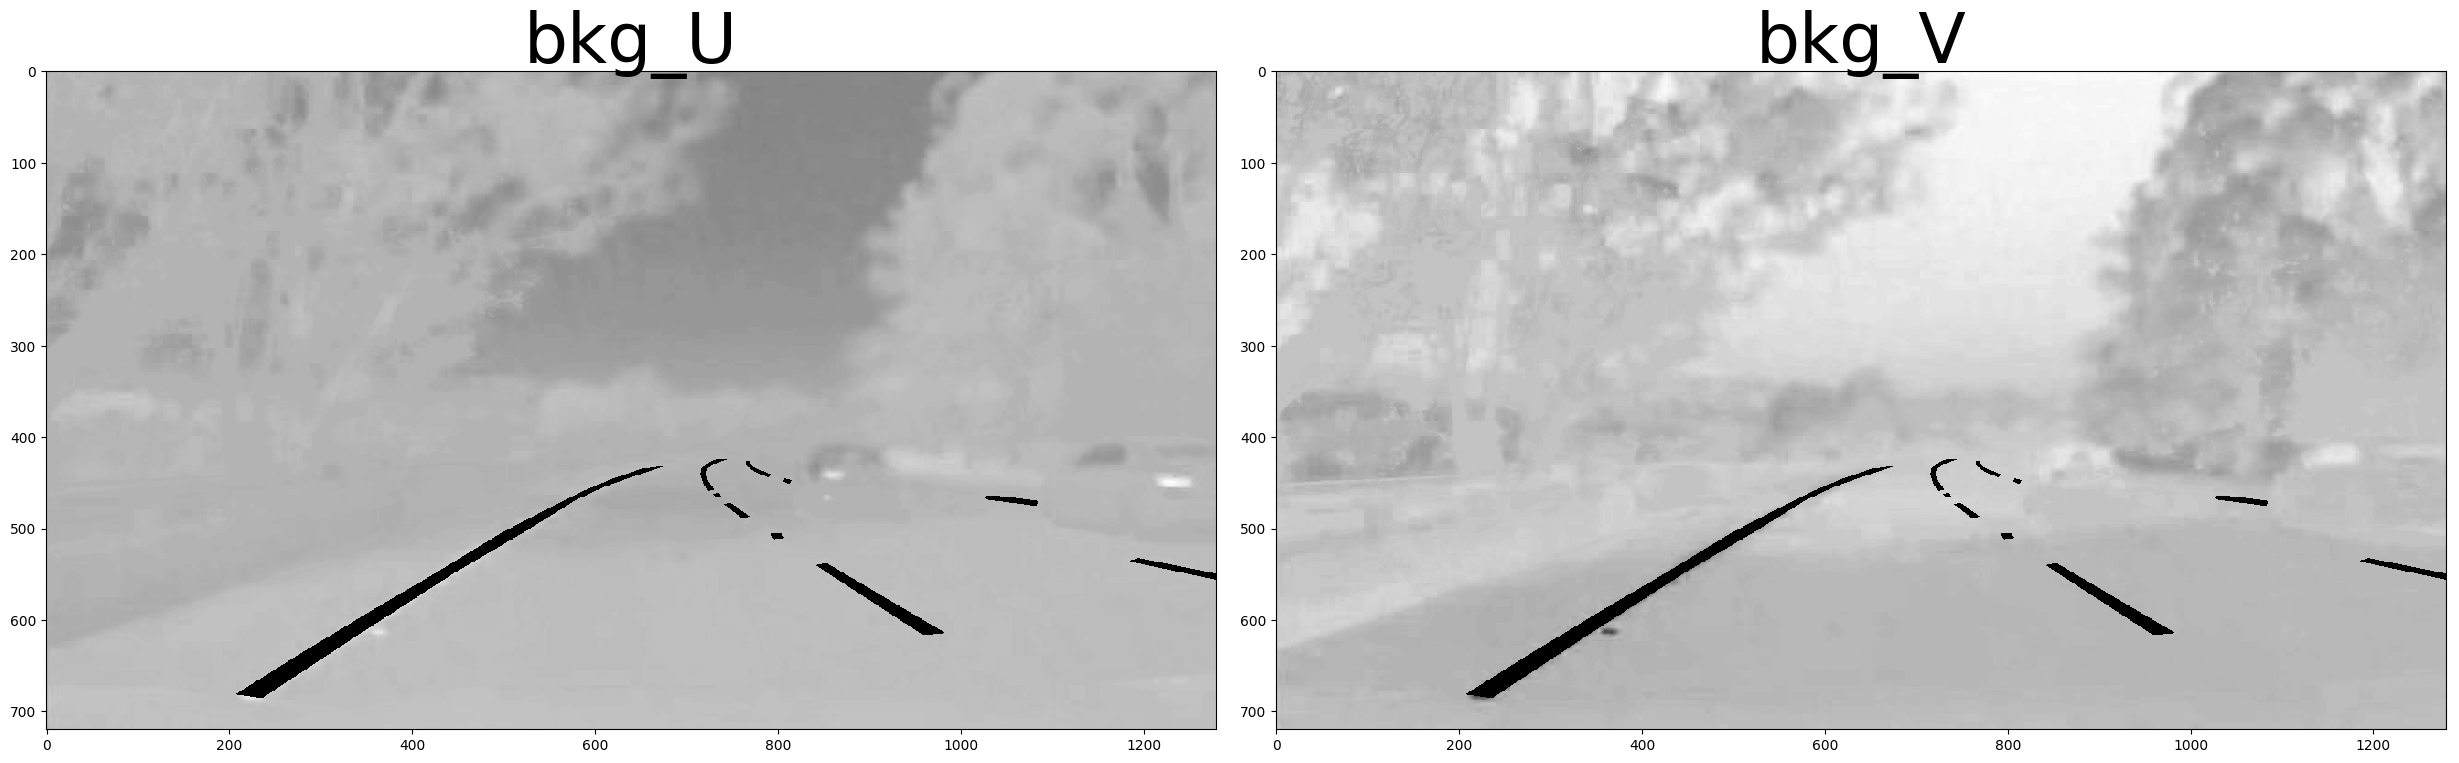

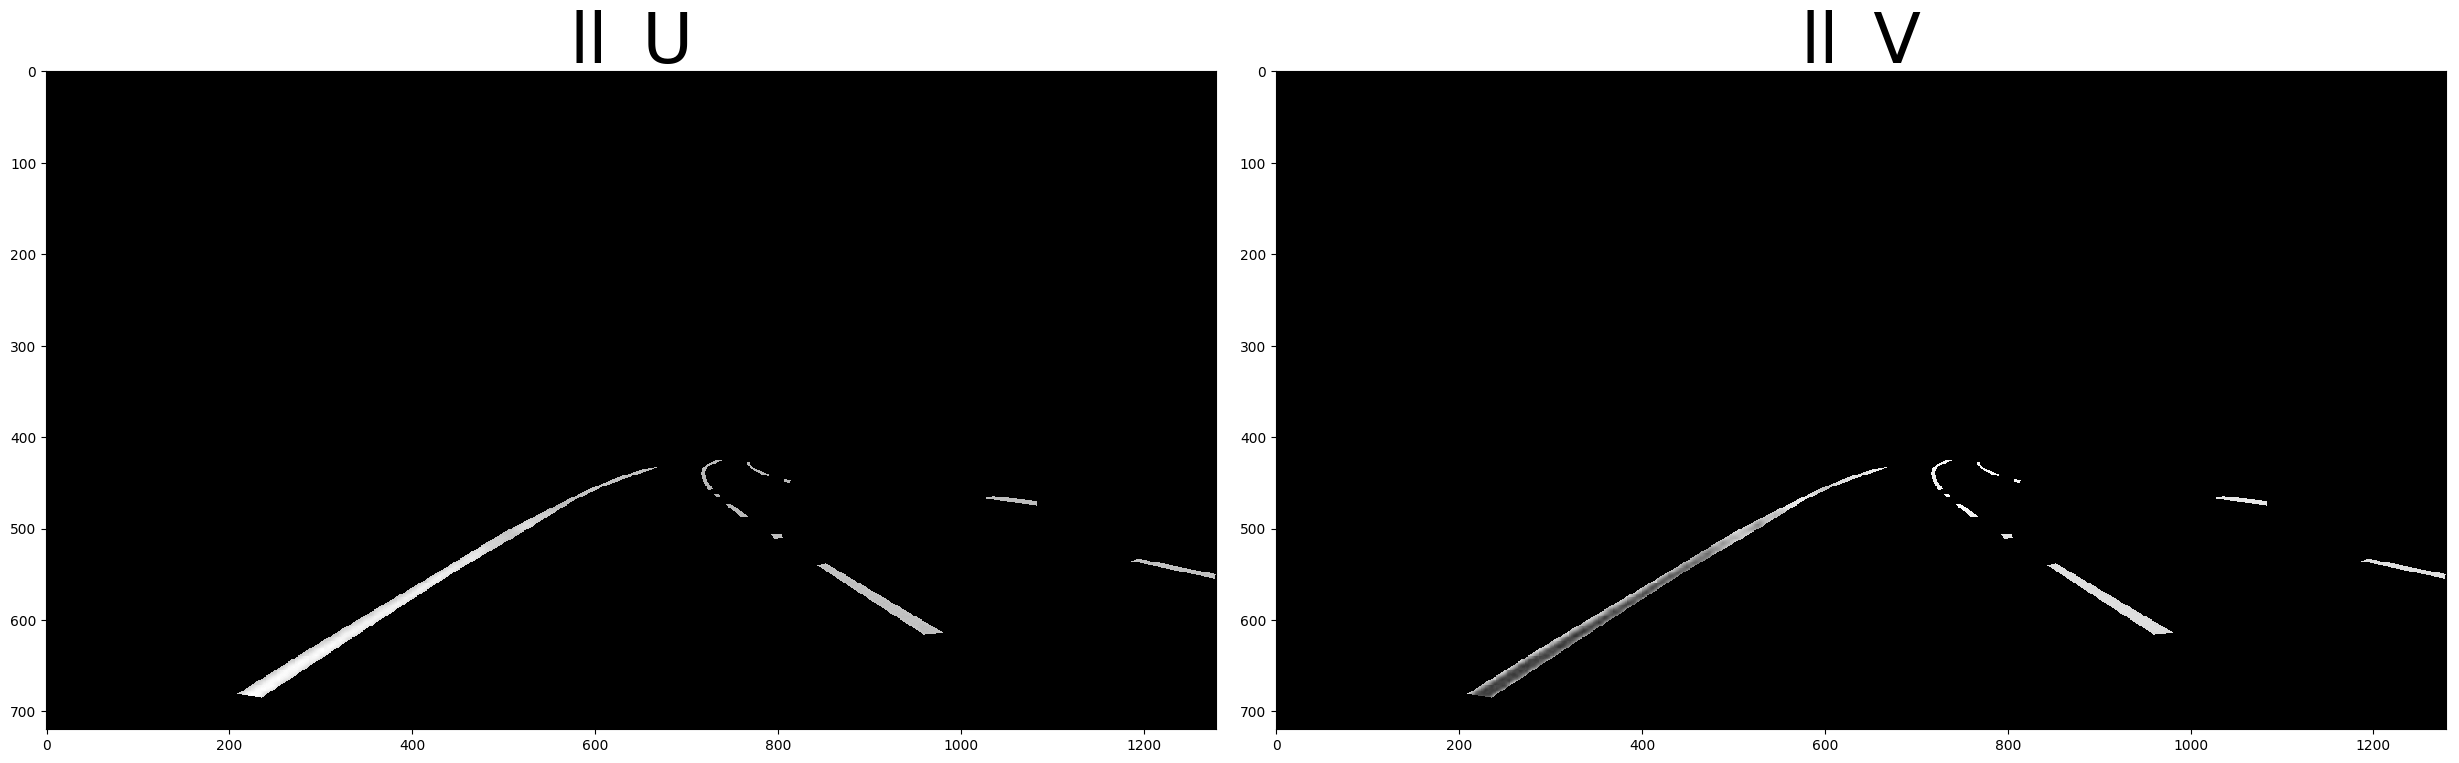

In [8]:
bkg_U = np.copy(U)
bkg_U[(mask[1] == 0)] = 0
bkg_V = np.copy(V)
bkg_V[(mask[1] == 0)] = 0

ll_U = np.copy(U)
ll_U[(mask[0] == 0)] = 0
ll_V = np.copy(V)
ll_V[(mask[0] == 0)] = 0

display_n_images((bkg_U, bkg_V), ("bkg_U", 'bkg_V'), ("gray", "gray"))
display_n_images((ll_U, ll_V), ("ll_U", 'll_V'), ("gray", "gray"))

In [9]:
'''
UV = np.stack([U, V]).transpose()
print(UV.shape)

fig, ax = plt.subplots()
ax.scatter(bkg_U, bkg_V, alpha=0.01, edgecolors='none', label='back')
ax.scatter(ll_U, ll_V, alpha=0.01, edgecolors='none', label='lines')
ax.legend()
ax.grid(True)

plt.show()
'''

"\nUV = np.stack([U, V]).transpose()\nprint(UV.shape)\n\nfig, ax = plt.subplots()\nax.scatter(bkg_U, bkg_V, alpha=0.01, edgecolors='none', label='back')\nax.scatter(ll_U, ll_V, alpha=0.01, edgecolors='none', label='lines')\nax.legend()\nax.grid(True)\n\nplt.show()\n"

In [10]:
'''
organize UV into array of X, which is the uv pair of values at a pixel,
and y which is the integer class of the pixel, 0 for background,
1 for lane line
'''
X = []
y = []

def get_train(U_mask, V_mask, X, y, class_n):
    for i in range(U_mask.shape[0]):
        for j in range(U_mask.shape[1]):
            pu = U_mask[i][j]
            pv = V_mask[i][j]
            if pu > 0:
                X.append((pu, pv))
                y.append(class_n)
        
get_train(bkg_U, bkg_V, X, y, 0)
get_train(ll_U, ll_V, X, y, 1)


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [12]:
'''
There's too many points to train on, just sample N of them for each class
'''
import random

def get_n(X_in, y_in, num, classes):
    n = len(X_in)
    X_ret = []
    y_ret = []
    n_classes = len(classes)
    n_per_class = num // n_classes
    for k in classes:
        for i in range(n_per_class):
            iSample = random.randrange(0, n)
            while y_in[iSample] != k:
                iSample = random.randrange(0, n)               
            X_ret.append(X_in[iSample])
            y_ret.append(y_in[iSample])
    return np.array(X_ret), np.array(y_ret)

'''
Seperate equal examples of the two classes by random sampling
'''
classes = (0, 1)
X_s, y_s = get_n(X, y, 10000, classes)


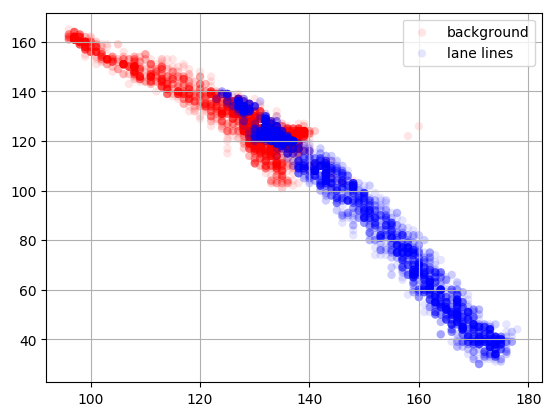

In [13]:
'''
Plot of sample of two classes UV value - in YUV spectrum
'''
fig, ax = plt.subplots()
colors = ("red", "blue")
labels = ("background", "lane lines")
for k in range(0, 2):
    idx = (y_s == k)
    label = labels[k]
    if idx.any():
        ax.scatter(X_s[idx, 0], X_s[idx, 1], c=colors[k], alpha=0.1, edgecolors='none', label=label)
ax.legend()
ax.grid(True)
plt.show()

In [14]:
'''
Train SVM with rbf kernel
'''

svc = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=10000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

svc.fit(X_s, y_s)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

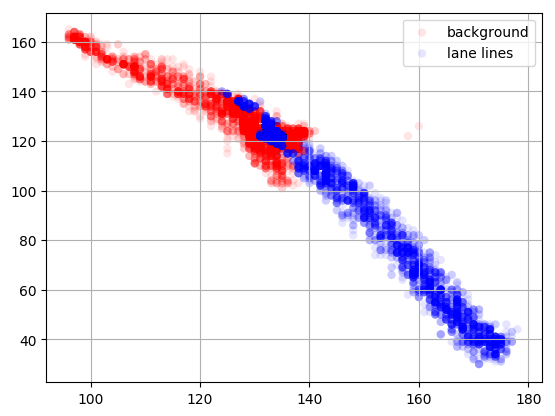

In [15]:
'''
Plot of predictions of two classes UV value - in YUV spectrum
'''
fig, ax = plt.subplots()
colors = ("red", "blue")
labels = ("background", "lane lines")
pred_s = svc.predict(X_s)

for k in range(0, 2):
    idx = (pred_s == k)
    label = labels[k]
    if idx.any():
        ax.scatter(X_s[idx, 0], X_s[idx, 1], c=colors[k], alpha=0.1, edgecolors='none', label=label)
ax.legend()
ax.grid(True)
plt.show()


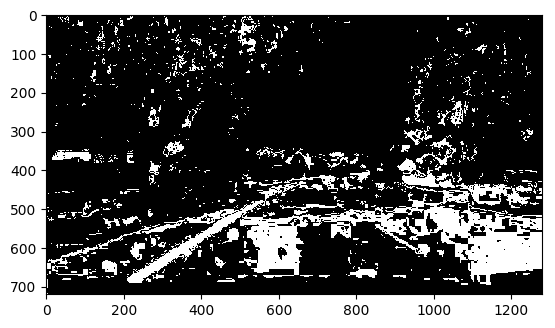

In [16]:
'''
run prediction on every pixel in the image
'''
UV_mask = np.copy(U) * 0

h, w = U.shape
UV = np.stack([U, V]).transpose().reshape(h * w, 2)

pred = svc.predict(UV)

'''
show prediction mask
'''

rshp_pred = pred.reshape(w, h)
mask = UV_mask.reshape(w, h)
mask[(rshp_pred == 1)] = 1
plt.imshow(mask.transpose(), cmap='gray')
plt.show()


In [17]:
'''
Seperate equal examples of the two classes by random sampling
'''
classes = (0, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_s, y_s = get_n(X, y, 10000, classes)

In [18]:
svc = SVC(kernel='linear')

svc.fit(X_s, y_s)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

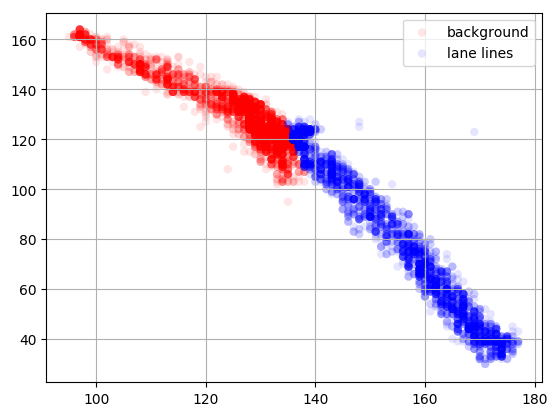

In [19]:
'''
Plot of predictions of two classes UV value - in YUV spectrum
'''
fig, ax = plt.subplots()
colors = ("red", "blue")
labels = ("background", "lane lines")
pred_s = svc.predict(X_s)

for k in range(0, 2):
    idx = (pred_s == k)
    label = labels[k]
    if idx.any():
        ax.scatter(X_s[idx, 0], X_s[idx, 1], c=colors[k], alpha=0.1, edgecolors='none', label=label)
ax.legend()
ax.grid(True)
plt.show()

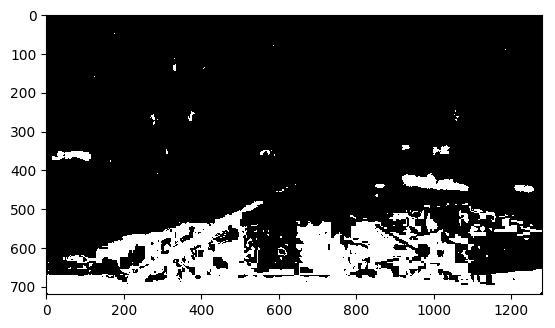

In [20]:
'''
run prediction on every pixel in the image
'''
UV_mask = np.copy(U) * 0

h, w = U.shape
UV = np.stack([U, V]).transpose().reshape(h * w, 2)

pred = svc.predict(UV)

'''
show prediction mask
'''

rshp_pred = pred.reshape(w, h)
mask = UV_mask.reshape(w, h)
mask[(rshp_pred == 1)] = 1
plt.imshow(mask.transpose(), cmap='gray')
plt.show()
